In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import mat4py
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
import pickle as pkl
from style import *
import viz

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = data_tracks.get_data()

# look at tracks themselves

In [4]:
auxilin_dir = '/scratch/users/vision/data/abc_data/auxilin_data_tracked'

    # 8 cell folders [1, 2, 3, ..., 8]
cell_num = 1
fname = f'{auxilin_dir}/A7D2/Cell{cell_num}_1s/TagRFP/Tracking/ProcessedTracks.mat'
# cla, aux = get_images(f'Cell{cell_num}_1s', auxilin_dir=auxilin_dir)
# fname_image = data_dir = oj(auxilin_dir, 'A7D2', f'Cell{cell_num}_1s')
mat = mat4py.loadmat(fname)
tracks = mat['tracks']

In [5]:
tracks.keys()

dict_keys(['t', 'f', 'x', 'y', 'A', 'c', 'x_pstd', 'y_pstd', 'A_pstd', 'c_pstd', 'sigma_r', 'SE_sigma_r', 'pval_Ar', 'isPSF', 'tracksFeatIndxCG', 'gapVect', 'gapStatus', 'gapIdx', 'seqOfEvents', 'nSeg', 'visibility', 'lifetime_s', 'start', 'end', 'startBuffer', 'endBuffer', 'MotionAnalysis', 'maskA', 'maskN', 'RSS', 'mask_Ar', 'hval_Ar', 'hval_AD', 'catIdx', 'isCCP', 'significantMaster', 'significantVsBackground', 'significantSlave'])

# visualize a single example

In [ ]:
# pick a single interesting example
# ex = df[df.lifetime > 250].iloc[0]
ex = df[(df.lifetime > 30) * (df.y_consec_sig == 1)]
ex = ex.sort_values(by='Y_max')
# .iloc[5]
ex = ex.iloc[-5]
plt.figure(dpi=200)
plt.plot(ex['X'], color='red', label='clathrin')
plt.plot(ex['Y'], color='green', label='auxilin')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# basic eda

In [ ]:
viz.plot_curves(df, hline=False)

In [ ]:
plt.plot(df['x_pos'], df['y_pos'], 'o', alpha=0.1)

# look at learned dictionaries

In [ ]:
print(os.listdir('processed/dictionaries'))
# d = pkl.load(open(f'processed/dictionaries/' + 'sc_12_alpha=1.pkl', 'rb'))
d = pkl.load(open(f'processed/dictionaries/' + 'nmf_12.pkl', 'rb'))
R, C = 3, 4
i = 0
plt.figure(dpi=200)
vmin = d.components_.min()
vmax = d.components_.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        plt.plot(d.components_[i], color=cr)
        i += 1
        plt.ylim((vmin, vmax))
        if r < R-1:
            plt.xticks([])
        if c > 0:
            plt.yticks([])
plt.tight_layout()
plt.show()

# viz tracks where auxilin peaks first

In [ ]:
outcomes = ['y_thresh', 'y_consec_sig', 'y_consec_thresh']
for outcome in outcomes:
    X_peak_idx = np.array([np.argmax(x) for x in df.X])
    Y_peak_idx = np.array([np.argmax(y) for y in df.Y])
    idxs_err = Y_peak_idx < X_peak_idx
    df_err = df[idxs_err]
    df_err_pos = df_err[df_err[outcome] == 1]
    num_pos = df[df[outcome] == 1].shape[0]
    num_pos_err = df_err_pos.shape[0] 
    frac_pos_err = num_pos_err / num_pos
    print('num tot', df.shape[0], 'num aux peaks first', df_err.shape[0], f'frac pos aux peaks first {frac_pos_err:0.3f}')
    viz.plot_curves(df_err_pos)

In [ ]:
plt.figure(dpi=300)
plt.hist(df_err_pos.lifetime, bins=20, color=cb)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title('aux+ with auxilin peaking first')
plt.show()

In [ ]:
R, C = 2, 1
plt.figure(dpi=200)
plt.subplot(R, C, 1)
plt.hist(X_peak_idx[idxs_err], color=cr)
plt.xlabel('Clathrin peak time')
plt.ylabel('Count')
plt.subplot(R, C, 2)
plt.hist(Y_peak_idx[idxs_err], color=cr)
plt.xlabel('Auxilin peak time')
plt.ylabel('Count')
plt.tight_layout()

# visualize splines

In [ ]:
viz.plot_curves(df_err, extra_key='X_smooth_spl')

# analyze tracking

In [1]:
fname = f'/scratch/users/vision/data/abc_data/auxilin_data_tracked/A7D2/Cell1_1s/TagRFP/Tracking/ProcessedTracks.mat'
mat = mat4py.loadmat(fname)
tracks = mat['tracks']

In [3]:
i = 2
x = tracks['x'][i][0]
xx = tracks['x'][i][1]

print('clath', len(x), 'aux', len(xx))

clath 300 aux 300


In [ ]:
for i in range(1000):
    print(tracks['t'][i][:5])

# new feats
**gets the clathrin traces aligned by their maximum, padded by zeros when necessary**

In [75]:
def get_peak(row, num=21):
    vals = np.empty(2 * num + 1) * np.nan 
    # vals = np.zeros(2 * num + 1)
    x = row['X']
    peak_idx = row['X_peak_idx']
    x_before = x[max(0,  peak_idx - num): peak_idx]
    
    vals[num - len(x_before): num] = x_before
    vals[num] = x[peak_idx]
    
    x_after = x[peak_idx + 1: peak_idx + num + 1]
    vals[num + 1: num + 1 + len(x_after)] = x_after
    return vals
mat = np.vstack(df.apply(get_peak, axis=1).values)
window_size = mat[0].size
mid = (window_size // 2)

In [ ]:
outcome_def = 'y_consec_thresh'
R, C = 8, 8
i = 0
plt.figure(figsize=(C, R), dpi=200)
vmin = np.nanmin(mat)
vmax = np.nanmax(mat)
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))

pos = df[outcome_def]==1
args = np.argsort(df[pos]['fall_local_11'].values)
mat_pos = mat[pos][args]
falls = df['fall_local_11'][pos].iloc[args].values

for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        plt.title(f'{falls[i]:.2e}')
        plt.plot(mat_pos[i * 8], color=cb, lw=1)
        plt.plot(mid, mat_pos[i * 8][mid], 'o', color='white', ms=2)
        
        
        plt.ylim((vmin, vmax))
        if r < R-1:
            plt.xticks([])
        if c > 0:
            plt.yticks([])
            
        i += 1
plt.tight_layout()
# plt.savefig('peak_aligned.pdf')
plt.show()

# pairplot of most relevant feats

In [ ]:
d = df[['fall', 'X_max', 'rise', 'X_mean', 'y_consec_sig']]
sns.pairplot(d, hue='y_consec_sig')
plt.show()

/accounts/projects/vision/.local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/accounts/projects/vision/.local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


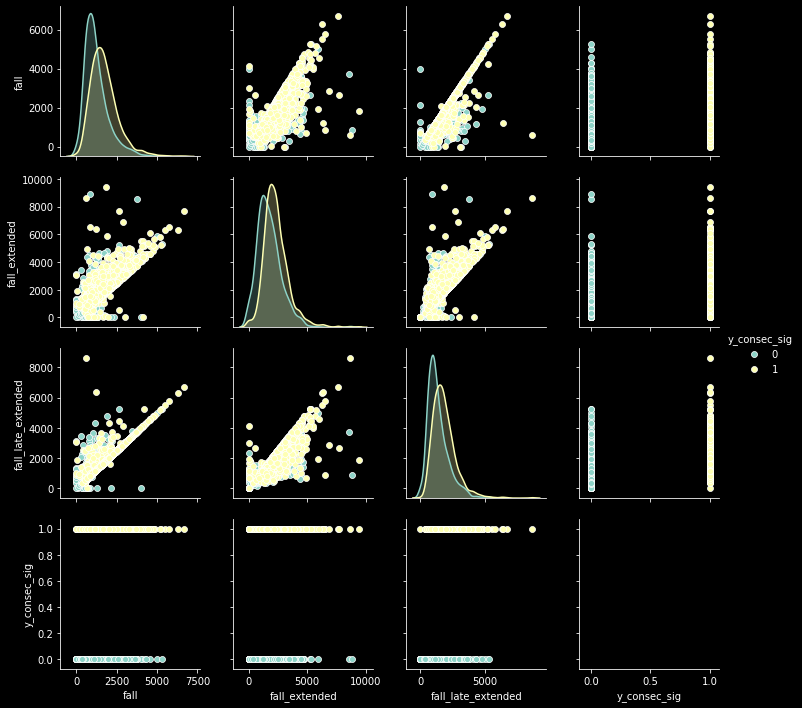

In [14]:
d = df[['fall', 'fall_extended', 'fall_late_extended'] + ['y_consec_sig']]
sns.pairplot(d, hue='y_consec_sig')
plt.show()